In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
import scipy.stats as stats
import matplotlib.pyplot as plt

In [59]:
# Since our pipeline is not up and running yet, let's just import the traintestsplit function
from python_scripts.traintestsplit import custom_train_test_split

In [107]:
# Read in the cleaned CSV  for football
df_bb = pd.read_csv("cleaned_files/basketball_clean_supervised.csv")
df_fb = pd.read_csv("cleaned_files/football_clean_supervised.csv")
df_bb = df_bb.drop(columns=['Unnamed: 0', 'NAME','SPORT','institution_name_short'])
df_fb = df_fb.drop(columns=['Unnamed: 0', 'NAME','SPORT','institution_name_short'])
print("Basketball dataset shape: {}, Football dataset shape: {}".format(df_bb.shape,df_fb.shape))



Basketball dataset shape: (137, 20), Football dataset shape: (1263, 20)


In [108]:

##Split this and maybe don't use one_hot
def one_hot(data,cols):
    df = pd.get_dummies(data, columns=cols, drop_first=True)
    return df

In [109]:
df_fb= one_hot(df_fb,['STARCOLL','POS','ClassificationCode'])
df_bb= one_hot(df_bb,['STARCOLL','POS','ClassificationCode'])

In [110]:
df_bb.sample(5)

,GRADE,AGE,SKILL,NUMOFF,HEIGHT_IN,WEIGHT_LBS,COLLDIST_MI,NILVAL_LONG_USD,INSTA_LONG,TWIT_LONG,...,STARCOLL_West Virginia,STARCOLL_Winthrop,POS_2.0,POS_3.0,POS_4.0,POS_5.0,POS_6.0,POS_7.0,ClassificationCode_2.0,ClassificationCode_3.0
112,0.0,16.0,98.92,22.0,75.0,175.0,237.0,271000.0,1700.0,1700.0,...,0,0,1,0,0,0,0,0,0,0
131,0.0,16.0,98.62,25.0,77.0,190.0,189.0,216000.0,1339.0,528.0,...,0,0,1,0,0,0,0,0,0,0
24,2.0,18.0,95.83,16.0,80.0,210.0,281.0,65000.0,3800.0,2700.0,...,0,0,0,0,0,1,0,0,0,0
120,0.0,15.0,97.12,5.0,81.0,210.0,15.0,107000.0,113.0,113.0,...,0,0,0,0,0,1,0,0,0,0
104,1.0,19.1,95.47,19.0,74.0,180.0,2102.0,157000.0,60000.0,36000.0,...,0,0,0,0,0,0,0,0,0,0


In [111]:
# Split both dataset into Train, Test, and Validation sets

X_train_bb, y_train_bb, X_valid_bb, y_valid_bb, X_test_bb, y_test_bb = custom_train_test_split(df_bb)
X_train_fb, y_train_fb, X_valid_fb, y_valid_fb, X_test_fb, y_test_fb = custom_train_test_split(df_fb)

print(X_train_bb.shape, X_test_bb.shape, X_valid_bb.shape)
print(X_train_fb.shape, X_test_fb.shape, X_valid_fb.shape)



(80, 79) (42, 79) (15, 79)
(751, 118) (379, 118) (133, 118)


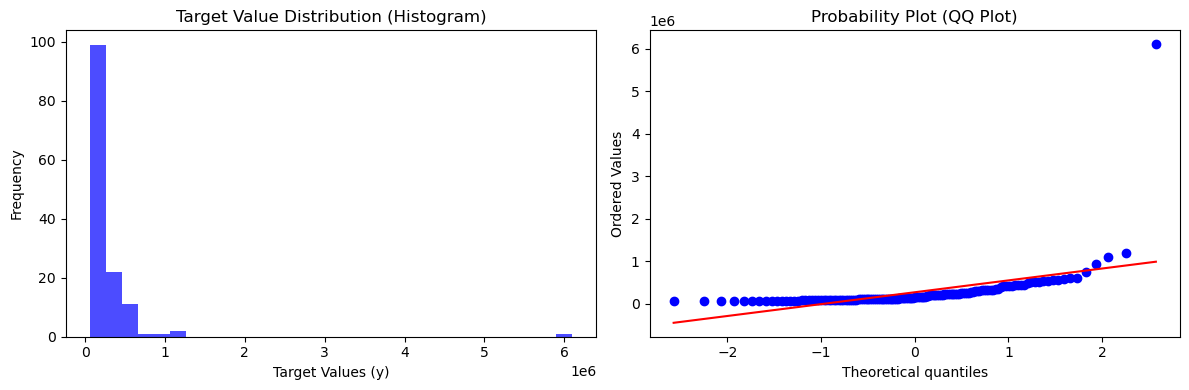

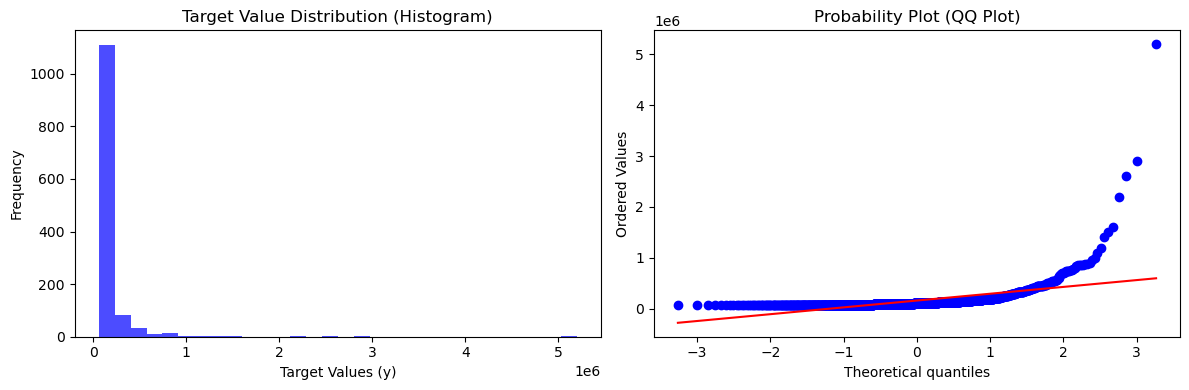

In [112]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(df_bb['NILVAL_LONG_USD'], bins=30, color='blue', alpha=0.7)
plt.title('Target Value Distribution (Histogram)')
plt.xlabel('Target Values (y)')
plt.ylabel('Frequency')

# Create a probability plot (QQ plot) to check for normality
plt.subplot(1, 2, 2)
stats.probplot(df_bb['NILVAL_LONG_USD'], dist="norm", plot=plt)
plt.title('Probability Plot (QQ Plot)')

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(df_fb['NILVAL_LONG_USD'], bins=30, color='blue', alpha=0.7)
plt.title('Target Value Distribution (Histogram)')
plt.xlabel('Target Values (y)')
plt.ylabel('Frequency')

# Create a probability plot (QQ plot) to check for normality
plt.subplot(1, 2, 2)
stats.probplot(df_fb['NILVAL_LONG_USD'], dist="norm", plot=plt)
plt.title('Probability Plot (QQ Plot)')

plt.tight_layout()
plt.show()

In [113]:
# Use this to remove outliers

In [114]:
features_bb = df_bb.columns
features_fb = df_fb.columns

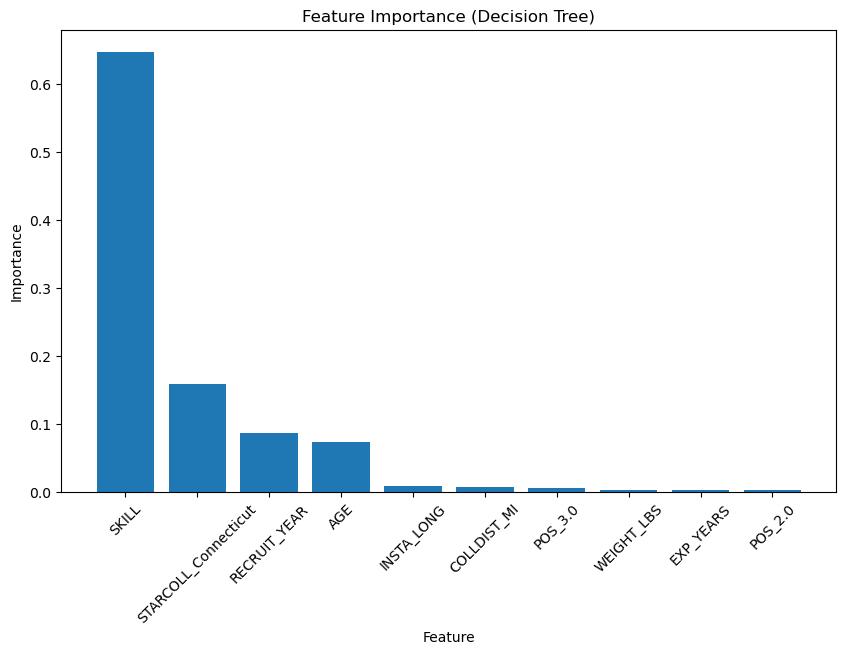

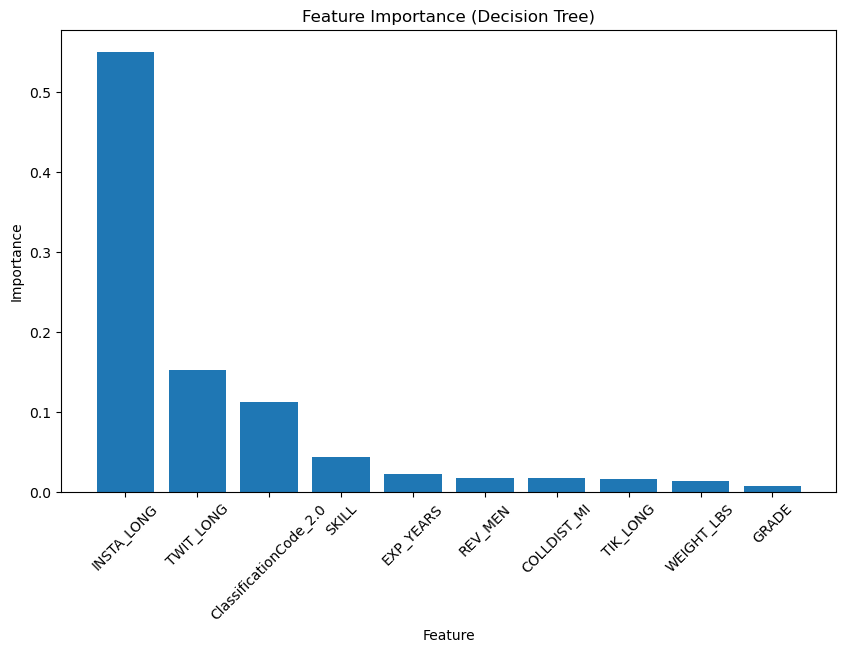

Selected Features for Dataset bb: ['SKILL', 'STARCOLL_Connecticut', 'RECRUIT_YEAR', 'AGE', 'INSTA_LONG', 'COLLDIST_MI', 'POS_3.0', 'WEIGHT_LBS', 'EXP_YEARS', 'POS_2.0']
Selected Features for Dataset fb: ['INSTA_LONG', 'TWIT_LONG', 'ClassificationCode_2.0', 'SKILL', 'EXP_YEARS', 'REV_MEN', 'COLLDIST_MI', 'TIK_LONG', 'WEIGHT_LBS', 'GRADE']


In [115]:
def feature_selection_tree_importance(X, y, features, n_features=5):
    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Create a DecisionTreeRegressor and fit it
    model = DecisionTreeRegressor()
    model.fit(X_scaled, y)

    # Get feature importances
    importances = model.feature_importances_

    # Visualize feature importances
    plt.figure(figsize=(10, 6))
    sorted_idx = np.argsort(importances)[::-1]
    #print([features[i] for i in sorted_idx[:n_features]])
    plt.bar(range(n_features), importances[sorted_idx][:n_features], align="center")
    plt.xticks(range(n_features), [features[i] for i in sorted_idx[:n_features]], rotation=45)
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.title('Feature Importance (Decision Tree)')
    plt.show()

    selected_features = [features[i] for i in sorted_idx[:n_features]]

    return selected_features

# Call the function for both datasets
selected_features_bb = feature_selection_tree_importance(X_train_bb, y_train_bb, features_bb,10)
selected_features_fb = feature_selection_tree_importance(X_train_fb, y_train_fb, features_fb,10)

print("Selected Features for Dataset bb:", selected_features_bb)
print("Selected Features for Dataset fb:", selected_features_fb)

In [116]:
def dummy_reg(X_train,y_train,X_test,y_test):

    mean_dummy = DummyRegressor(strategy="mean").fit(X_train, y_train)
    y_pred = mean_dummy.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return mse, r2

In [117]:
mse_bb, r2_bb = dummy_reg(X_train_bb,y_train_bb,X_test_bb,y_test_bb)
mse_fb, r2_fb = dummy_reg(X_train_fb,y_train_fb,X_test_fb,y_test_fb)
print("Mean squared error (dummy): {},r2_score (dummy): {}".format(mse_bb, r2_bb))
print("Mean squared error (dummy): {},r2_score (dummy): {}".format(mse_fb, r2_fb))


Mean squared error (dummy): 845018903787.2024,r2_score (dummy): -0.01688588932944035
Mean squared error (dummy): 23282564882.664856,r2_score (dummy): -0.005475359478686492


In [118]:
# Build a baseline random forest regressor
def Ran_For_Reg(X_train, y_train, X_test, y_test, random_state=0):
    # scaler = StandardScaler()
    # X_scaled = scaler.fit_transform(X_train)

    rf = RandomForestRegressor(random_state=random_state)
    rf.fit(X_train, y_train.values)
    y_pred = rf.predict(X_test)
    score_ = rf.score(X_test, y_test)
    mse = mean_squared_error(y_test,y_pred)
    return rf, score_, mse

In [119]:
# Baseline Random Forest
rf_bb, r2_score_bb, mse_bb = Ran_For_Reg(X_train_bb, y_train_bb, X_test_bb, y_test_bb)
rf_fb, r2_score_fb, mse_fb = Ran_For_Reg(X_train_fb, y_train_fb, X_test_fb, y_test_fb)
print("Mean squared error: {}, R2 Score: {}".format(mse_bb, r2_score_bb))
print("Mean squared error: {}, R2 Score: {}".format(mse_fb, r2_score_fb))

Mean squared error: 834660117102.381, R2 Score: -0.0044202462968896405
Mean squared error: 16440242444.854881, R2 Score: 0.29001556463115863


Performance is not very good, lets try to run it with only the most important features

In [120]:
# Random Forest w/Top 5 features from importance
rf_bb, r2_score_bb, mse_bb = Ran_For_Reg(X_train_bb[selected_features_bb[0:5]], y_train_bb, X_test_bb[selected_features_bb[0:5]], y_test_bb)
rf_fb, r2_score_fb, mse_bb = Ran_For_Reg(X_train_fb[selected_features_fb[0:5]], y_train_fb, X_test_fb[selected_features_fb[0:5]], y_test_fb)
print("Mean squared error: {}, R2 Score: {}".format(mse_bb, r2_score_bb))
print("Mean squared error: {}, R2 Score: {}".format(mse_fb, r2_score_fb))

Mean squared error: 16757048453.506596, R2 Score: -0.008039630202312908
Mean squared error: 16440242444.854881, R2 Score: 0.27633405501057284


Performance did not change for basketball and got worse for football, lets do a grid search to do further refinement

In [124]:
def grid_search(X_train,y_train,X_test,y_test):

    grid = { 
        'n_estimators': [100,200,300,400],
        'max_features': [12,13,14,15,16,17,'sqrt'],
        'max_depth' : [3,4,5,6,7,8,9]
    }
    
    
    rf = RandomForestRegressor(random_state=0)
    grid_rf = GridSearchCV(rf,param_grid=grid,cv=3)
    model_grid = grid_rf.fit(X_train,y_train)

    rf_best = model_grid.best_estimator_
    y_pred_test = rf_best.predict(X_test)
         
    # Calculate performance metrics
    rf_dict = {'Model':'Random Forest Regressor',
          'R^2':r2_score(y_test, y_pred_test),
          'MSE':mean_squared_error(y_test, y_pred_test),
          'RMSE':np.sqrt(mean_squared_error(y_test, y_pred_test))}

    # Display model performance metrics
    rf_reg_metrics = pd.DataFrame.from_dict(rf_dict, orient = 'index').T

    print(rf_best)
    
    return rf_best, y_pred_test, rf_reg_metrics


In [125]:
rf_best_bb, grid_pred_bb, bb_metrics = grid_search(X_train_bb,y_train_bb,X_valid_bb,y_valid_bb)
rf_best_fb, grid_pred_fb,fb_metrics = grid_search(X_train_fb,y_train_fb,X_valid_fb,y_valid_fb)
print(bb_metrics)
print(fb_metrics)


RandomForestRegressor(max_depth=6, max_features=15, n_estimators=200,
                      random_state=0)
RandomForestRegressor(max_depth=8, max_features=16, n_estimators=200,
                      random_state=0)
                     Model      R^2                 MSE           RMSE
0  Random Forest Regressor  0.04301  85606874206.845276  292586.524308
                     Model       R^2               MSE          RMSE
0  Random Forest Regressor  0.624934  3622292900.70952  60185.487459


In [126]:
y_pred_bb = rf_best_bb.predict(X_test_bb)
print("'R^2':{}, MSE:{},RMSE:{}".format(r2_score(y_test_bb, y_pred_bb),mean_squared_error(y_test_bb, y_pred_bb),np.sqrt(mean_squared_error(y_test_bb, y_pred_bb))))

y_pred_fb = rf_best_fb.predict(X_test_fb)
print("'R^2':{}, MSE:{},RMSE:{}".format(r2_score(y_test_fb, y_pred_fb),mean_squared_error(y_test_fb, y_pred_fb),np.sqrt(mean_squared_error(y_test_fb, y_pred_fb))))

'R^2':0.07920944490874726, MSE:765164935068.4851,RMSE:874737.066248187
'R^2':0.40074111665869083, MSE:13876306068.943575,RMSE:117797.73371734947


For football our performance has improved significantly! But for basketball we still don't have very good performance. Perhaps this is because Random Forests are not the best in this situation as we have a large number of sparse features due to the one hot encoding of universities and position <br>
Values with One Hot Encoding of Position and College <br>
BB: 'R^2':0.06831086471463321, MSE:774221512984.558,RMSE:879898.5810788411 <br>
FB: 'R^2':0.39611168670325925, MSE:13983504124.36183,RMSE:118251.86731871015

Values with One Hot Encoding of Position and College and classification code <br>
'R^2':0.0018413237631622614, MSE:829456834095.2572,RMSE:910745.2081099616 <br>
'R^2':0.25855016498752414, MSE:17168848274.779676,RMSE:131029.95182316017

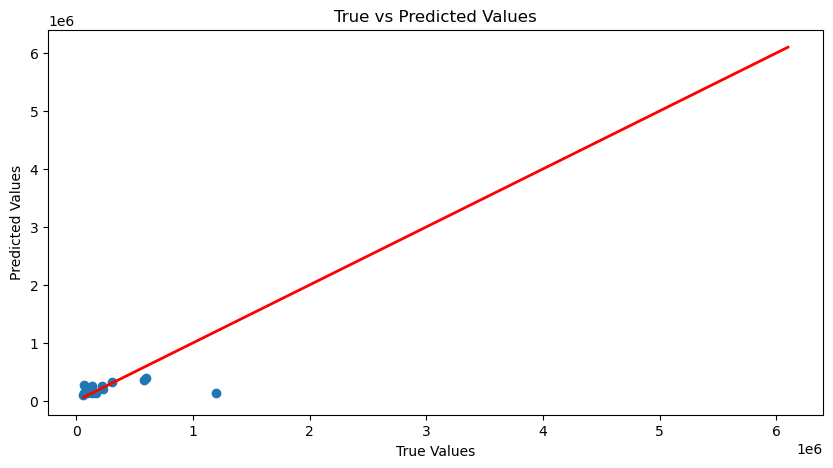

In [127]:

plt.figure(figsize=(10, 5))
plt.scatter(y_valid_bb, grid_pred_bb)
plt.plot([y_test_bb.min(), y_test_bb.max()], [y_test_bb.min(), y_test_bb.max()], color='red', linewidth=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.show()

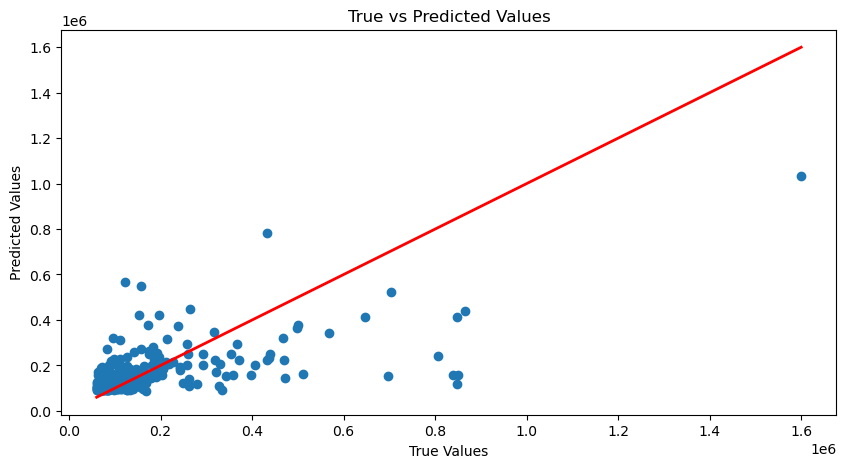

In [129]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test_fb, y_pred_fb)
plt.plot([y_test_fb.min(), y_test_fb.max()], [y_test_fb.min(), y_test_fb.max()], color='red', linewidth=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.show()